In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from format_the_data import format_mi_band_data
from feature_engineering import get_wake_up_info, get_heartrate_data_for_interval
import json
from pprint import pprint

In [2]:
### set os dir to data
os.chdir('/Users/Gerard/Downloads')
andy = pd.read_csv('20231030_8210796956_MiFitness_hlth_center_fitness_data.csv')
tom = pd.read_csv('20231030_8211531339_MiFitness_hlth_center_fitness_data.csv')
huub = pd.read_csv('20231031_8210564343_MiFitness_hlth_center_fitness_data.csv')
oumaima = pd.read_csv('20231110_8210586841_MiFitness_hlth_center_fitness_data.csv')

behaviour_tracking_data = pd.read_csv('Data app - Habits.csv')

In [3]:
andy['Person'] = 'andy'
tom['Person'] = 'tom'
huub['Person'] = 'huub'
oumaima['Person'] = 'oumaima'

master_frame = pd.concat([andy, tom, huub, oumaima], ignore_index=True)

In [4]:
unique_keys = ['pai',
               'valid_stand', 
               'calories',
               'steps',
               'heart_rate',
               'intensity',
               'dynamic',
               'single_heart_rate',
               'single_spo2',
               'training_load',
               'single_stress',
               'stress',
               'watch_night_sleep',
               'resting_heart_rate',
               'watch_daytime_sleep',
               'weight']
key_dataframes = format_mi_band_data(unique_keys, master_frame)


# separate dataframes:
pai_df = key_dataframes['pai']
valid_stand_df = key_dataframes['valid_stand']
calories_df = key_dataframes['calories']
steps_df = key_dataframes['steps']
heart_rate_df = key_dataframes['heart_rate']
intensity_df = key_dataframes['intensity']
dynamic_df = key_dataframes['dynamic']
single_heart_rate_df = key_dataframes['single_heart_rate']
single_spo2_df = key_dataframes['single_spo2']
training_load_df = key_dataframes['training_load']
single_stress_df = key_dataframes['single_stress']
stress_df = key_dataframes['stress']
watch_night_sleep_df = key_dataframes['watch_night_sleep']
resting_heart_rate_df = key_dataframes['resting_heart_rate']
watch_daytime_sleep_df = key_dataframes['watch_daytime_sleep']
weight_df = key_dataframes['weight']

# Intuition

I think we need to include control variables such as the number of hours sleep and the quality of sleep as this significantly influences your mental state after awaking.

I guess we can check whether someone has slept after their alarm right?

We must include variable for smart alarm or not. Can we find this in the settings from the mi band?

We are going to add features from our watch data to the behavioural data.

Features for our analysis:
- Average of the first 20 minutes after waking
- Whether the smart alarm actually woke us up in light sleep (not in deep or REM)

Hence we need:
- Waking time
- Heartrate data
- State when awaking

In [5]:
behaviour_tracking_data = get_wake_up_info(watch_night_sleep_df, behaviour_tracking_data)
behaviour_tracking_data

,Name,Drinks,Fastfood,Sports,Food 2huub before sleep,Medication,Date created,Woke up by (smart) alarm,Woke up by external factors,Yesterday,Slept again after alarm,Smart alarm,Date,time_of_awakening,state_before_awakening
0,andy,False,True,True,False,False,2023-10-01T08:41:41.000Z,True,False,False,False,False,2023-10-01,05:14:00,3.0
1,andy,False,True,False,False,False,2023-10-02T07:00:32.000Z,False,False,False,False,False,2023-10-02,05:04:00,3.0
2,andy,False,False,False,False,False,2023-10-03T05:31:28.000Z,True,False,False,False,False,2023-10-03,05:32:00,3.0
3,andy,False,False,False,False,False,2023-10-04T03:12:57.000Z,True,False,False,False,False,2023-10-04,03:12:00,3.0
4,andy,False,False,False,False,False,2023-10-05T07:00:29.000Z,True,False,False,False,False,2023-10-05,06:00:00,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,tom,False,False,True,False,False,2023-10-24T08:35:00.000Z,True,False,False,False,False,2023-10-24,04:56:00,3.0
115,tom,True,False,True,True,False,2023-10-25T07:12:00.000Z,True,False,False,False,False,2023-10-25,04:34:00,3.0
116,tom,False,True,True,False,False,2023-10-26T05:30:00.000Z,True,False,False,True,False,2023-10-26,04:37:00,3.0
117,tom,False,False,False,False,False,2023-10-27T08:03:00.000Z,True,False,False,False,False,2023-10-27,05:00:00,3.0


In [6]:
# filter out the rows where the time_of_awakening is NaN
behaviour_tracking_data = behaviour_tracking_data[~behaviour_tracking_data['time_of_awakening'].isna()].reset_index(drop=True)

time_interval = 30
# Apply the function to each row and store the results in a temporary column
#behaviour_tracking_data = behaviour_tracking_data[behaviour_tracking_data['Name'] == 'tom']
results_df = behaviour_tracking_data.apply(lambda row: get_heartrate_data_for_interval(heart_rate_df, row['Name'], row['Date'], row['time_of_awakening'], time_interval), axis=1)

split_results_df = pd.DataFrame(results_df.tolist(), columns=['number_of_measurements', 'average_heart_rate', 'average_lowest_three'])

andy 2023-10-01 05:14:00 30
10 76.9 64.66666666666667
andy 2023-10-02 05:04:00 30
14 72.35714285714286 67.66666666666667
andy 2023-10-03 05:32:00 30
11 71.0 64.0
andy 2023-10-04 03:12:00 30
14 69.92857142857143 60.666666666666664
andy 2023-10-05 06:00:00 30
11 84.0909090909091 76.66666666666667
andy 2023-10-06 05:02:00 30
14 74.71428571428571 61.0
andy 2023-10-07 06:15:00 30
15 67.86666666666666 61.0
andy 2023-10-08 05:29:00 30
11 74.81818181818181 66.33333333333333
andy 2023-10-09 03:46:00 30
1 84.0 None
andy 2023-10-10 06:15:00 30
14 72.57142857142857 65.66666666666667
andy 2023-10-11 04:14:00 30
10 74.1 59.333333333333336
andy 2023-10-12 03:01:00 30
10 66.6 60.666666666666664
andy 2023-10-13 06:05:00 30
3 81.33333333333333 81.33333333333333
andy 2023-10-14 06:50:00 30
9 68.66666666666667 62.333333333333336
andy 2023-10-15 05:30:00 30
12 64.08333333333333 57.0
andy 2023-10-16 05:00:00 30
14 72.5 63.0
andy 2023-10-17 04:42:00 30
13 71.15384615384616 63.666666666666664
andy 2023-10-18 

In [7]:
print(len(split_results_df), len(behaviour_tracking_data))

86 86


In [8]:
behaviour_tracking_data['number_of_measurements'] = split_results_df['number_of_measurements']
behaviour_tracking_data['average_heart_rate'] = split_results_df['average_heart_rate']
behaviour_tracking_data['average_lowest_three'] = split_results_df['average_lowest_three']
behaviour_tracking_data

,Name,Drinks,Fastfood,Sports,Food 2huub before sleep,Medication,Date created,Woke up by (smart) alarm,Woke up by external factors,Yesterday,Slept again after alarm,Smart alarm,Date,time_of_awakening,state_before_awakening,number_of_measurements,average_heart_rate,average_lowest_three
0,andy,False,True,True,False,False,2023-10-01T08:41:41.000Z,True,False,False,False,False,2023-10-01,05:14:00,3.0,10,76.900000,64.666667
1,andy,False,True,False,False,False,2023-10-02T07:00:32.000Z,False,False,False,False,False,2023-10-02,05:04:00,3.0,14,72.357143,67.666667
2,andy,False,False,False,False,False,2023-10-03T05:31:28.000Z,True,False,False,False,False,2023-10-03,05:32:00,3.0,11,71.000000,64.000000
3,andy,False,False,False,False,False,2023-10-04T03:12:57.000Z,True,False,False,False,False,2023-10-04,03:12:00,3.0,14,69.928571,60.666667
4,andy,False,False,False,False,False,2023-10-05T07:00:29.000Z,True,False,False,False,False,2023-10-05,06:00:00,3.0,11,84.090909,76.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,tom,False,False,True,False,False,2023-10-24T08:35:00.000Z,True,False,False,False,False,2023-10-24,04:56:00,3.0,30,74.900000,49.000000
82,tom,True,False,True,True,False,2023-10-25T07:12:00.000Z,True,False,False,False,False,2023-10-25,04:34:00,3.0,30,84.200000,71.333333
83,tom,False,True,True,False,False,2023-10-26T05:30:00.000Z,True,False,False,True,False,2023-10-26,04:37:00,3.0,30,66.300000,47.666667
84,tom,False,False,False,False,False,2023-10-27T08:03:00.000Z,True,False,False,False,False,2023-10-27,05:00:00,3.0,30,80.666667,63.000000


In [9]:
# CHECK FOR OUMAIMAS DATA AFTER 2023-10-01
temp = pd.DataFrame()
temp['DateTime'] = pd.to_datetime(watch_night_sleep_df['Time'], unit='s')
watch_night_sleep_df['obs_date'] = temp['DateTime'].dt.date
watch_night_sleep_df['obs_time'] = temp['DateTime'].dt.time

date = pd.to_datetime('2023-10-01').date()
filtered_df = watch_night_sleep_df[(watch_night_sleep_df['Person'] == 'oumaima') & (watch_night_sleep_df['obs_date'] >= date)]
len(filtered_df)

18

In [10]:
behaviour_tracking_data[behaviour_tracking_data['Name'] == 'tom'].head()


,Name,Drinks,Fastfood,Sports,Food 2huub before sleep,Medication,Date created,Woke up by (smart) alarm,Woke up by external factors,Yesterday,Slept again after alarm,Smart alarm,Date,time_of_awakening,state_before_awakening,number_of_measurements,average_heart_rate,average_lowest_three
59,tom,True,True,False,True,False,2023-10-01T08:35:18.000Z,True,False,False,True,True,2023-10-01,07:50:00,3.0,30,77.566667,62.333333
60,tom,False,False,True,False,False,2023-10-02T10:26:15.000Z,True,False,False,False,True,2023-10-02,04:42:00,3.0,30,78.133333,52.000000
61,tom,False,False,True,False,False,2023-10-03T21:47:24.000Z,False,False,False,False,True,2023-10-03,04:07:00,3.0,30,51.433333,40.666667
62,tom,False,False,False,False,False,2023-10-04T08:37:45.000Z,True,False,False,False,True,2023-10-04,06:29:00,3.0,30,83.200000,60.666667
63,tom,False,False,False,False,False,2023-10-05T06:40:51.000Z,True,False,False,False,True,2023-10-05,05:01:00,3.0,30,72.400000,44.666667


In [11]:
# SAVE total_df to csv
behaviour_tracking_data.to_csv('PREPROCESSED_DATA.csv', index=False)

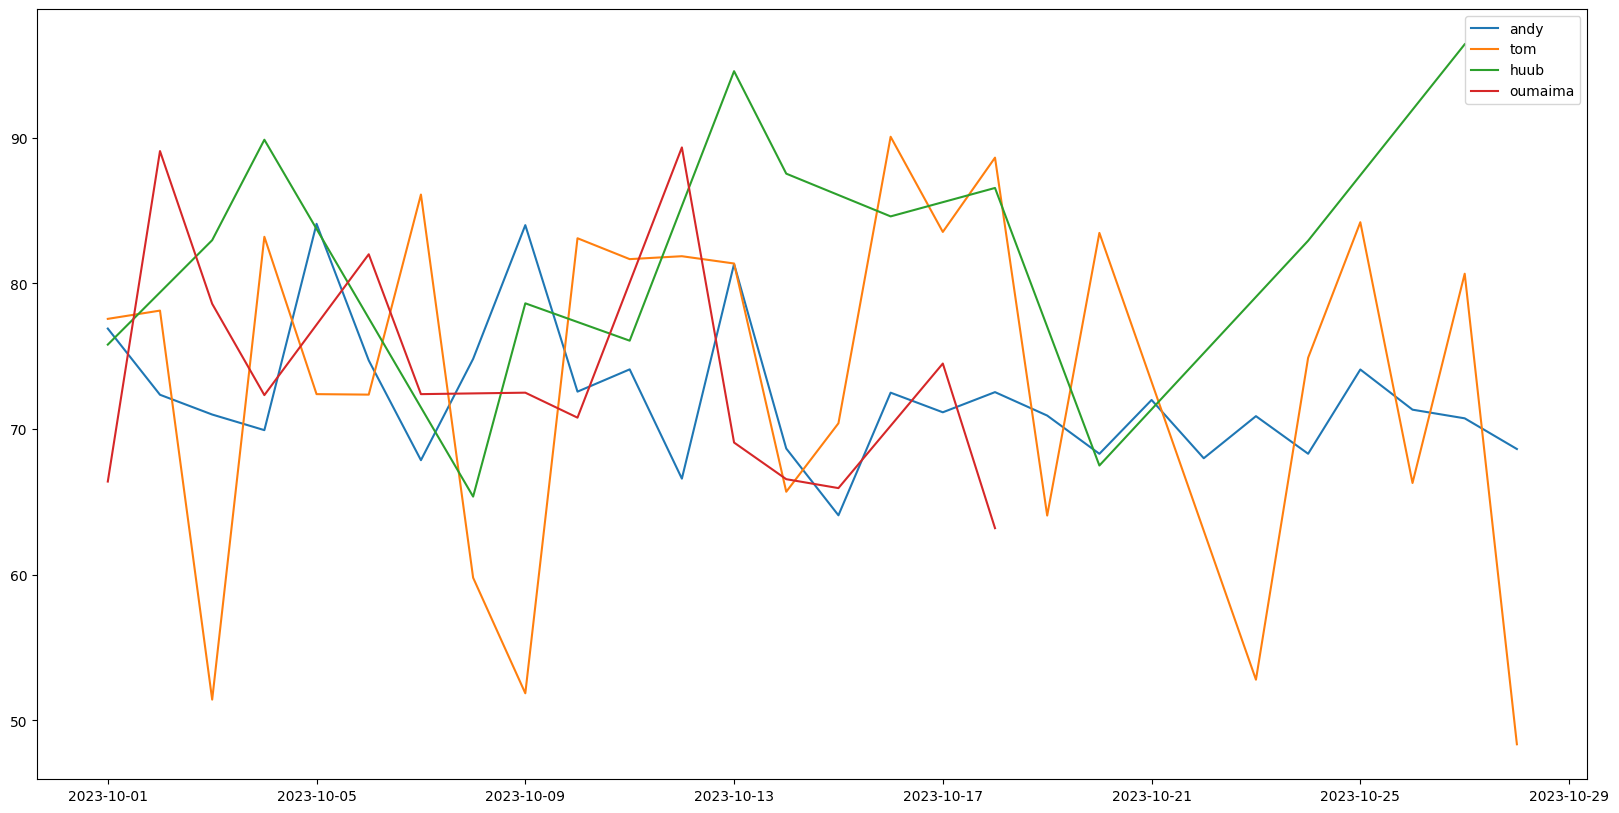

In [12]:
# plot the average heartrate for each person over time
total_df = behaviour_tracking_data
plt.figure(figsize=(20,10))
plt.plot(total_df[total_df['Name'] == 'andy']['Date'], total_df[total_df['Name'] == 'andy']['average_heart_rate'], label='andy')
plt.plot(total_df[total_df['Name'] == 'tom']['Date'], total_df[total_df['Name'] == 'tom']['average_heart_rate'], label='tom')
plt.plot(total_df[total_df['Name'] == 'huub']['Date'], total_df[total_df['Name'] == 'huub']['average_heart_rate'], label='huub')
plt.plot(total_df[total_df['Name'] == 'oumaima']['Date'], total_df[total_df['Name'] == 'oumaima']['average_heart_rate'], label='oumaima')
plt.legend()
plt.show()


In [13]:
# CHECK IF ALL DATA IS MATCHED WITH THE FORM DATA
print('behaviour_tracking_data has {} rows'.format(len(behaviour_tracking_data)))
print('')

# print the number of observations for each name in behaviour_tracking_data
print(behaviour_tracking_data['Name'].value_counts())
print('')
print(behaviour_tracking_data['Smart alarm'].value_counts())
print('')
# split the dataframe for smart alarm true and false
smart_alarm_true = behaviour_tracking_data[behaviour_tracking_data['Smart alarm'] == True]
smart_alarm_false = behaviour_tracking_data[behaviour_tracking_data['Smart alarm'] == False]
print('')
# print state of awakening for smart alarm true and false
print(smart_alarm_true['state_before_awakening'].value_counts())
print('')
print(smart_alarm_false['state_before_awakening'].value_counts())

# display the rows in behaviour_tracking_data where state_before_awakening is NaN
behaviour_tracking_data[behaviour_tracking_data['state_before_awakening'].isna()]

behaviour_tracking_data has 86 rows

Name
andy       28
tom        27
oumaima    16
huub       15
Name: count, dtype: int64

Smart alarm
False    49
True     37
Name: count, dtype: int64


state_before_awakening
3.0    37
Name: count, dtype: int64

state_before_awakening
3.0    48
4.0     1
Name: count, dtype: int64


,Name,Drinks,Fastfood,Sports,Food 2huub before sleep,Medication,Date created,Woke up by (smart) alarm,Woke up by external factors,Yesterday,Slept again after alarm,Smart alarm,Date,time_of_awakening,state_before_awakening,number_of_measurements,average_heart_rate,average_lowest_three


## Conclusie

Als we smartwake gebruiken worden we wakker in light sleep en als we een normaal alarm gebruiken ook.
Dit kan een gevolg zijn van het geval dat het smart alarm van ons horloge niet beter werkt dan normaal.
Systematic failure. -> naja we worden juist wel wakker in light sleep, dus t werkt wel.

Mochten we geen significante resultaten vinden, zou dit een oorzaak kunnen zijn.

Now we need to get save the wake time into the behavioural dataframe